<a href="https://colab.research.google.com/github/SABBIRAHAMMED3/ML/blob/main/Flood_Routing_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Epoch 1/100


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


31/31 - 3s - 83ms/step - loss: 0.0593 - val_loss: 0.0190 - learning_rate: 1.0000e-03
Epoch 2/100
31/31 - 1s - 30ms/step - loss: 0.0221 - val_loss: 0.0069 - learning_rate: 1.0000e-03
Epoch 3/100
31/31 - 1s - 20ms/step - loss: 0.0141 - val_loss: 0.0070 - learning_rate: 1.0000e-03
Epoch 4/100
31/31 - 0s - 10ms/step - loss: 0.0139 - val_loss: 0.0099 - learning_rate: 1.0000e-03
Epoch 5/100
31/31 - 1s - 21ms/step - loss: 0.0100 - val_loss: 0.0042 - learning_rate: 1.0000e-03
Epoch 6/100
31/31 - 1s - 19ms/step - loss: 0.0071 - val_loss: 0.0045 - learning_rate: 1.0000e-03
Epoch 7/100
31/31 - 0s - 10ms/step - loss: 0.0065 - val_loss: 0.0076 - learning_rate: 1.0000e-03
Epoch 8/100
31/31 - 0s - 10ms/step - loss: 0.0064 - val_loss: 0.0056 - learning_rate: 1.0000e-03
Epoch 9/100
31/31 - 1s - 17ms/step - loss: 0.0069 - val_loss: 0.0046 - learning_rate: 1.0000e-03
Epoch 10/100
31/31 - 1s - 20ms/step - loss: 0.0054 - val_loss: 0.0040 - learning_rate: 1.0000e-03
Epoch 11/100
31/31 - 0s - 15ms/step - los

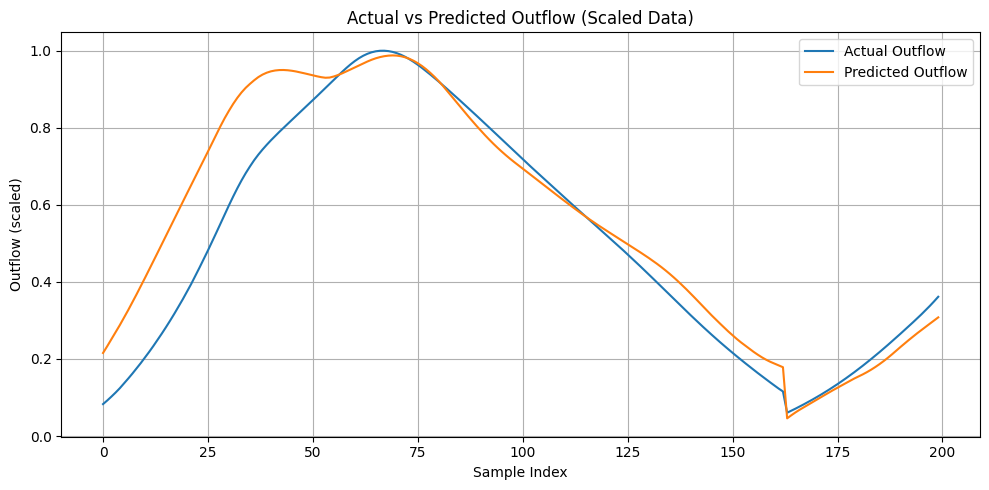

In [ ]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import matplotlib.pyplot as plt

# 1. Load inflow and outflow CSVs
inflow_df = pd.read_csv('/content/Inflow.csv')
outflow_df = pd.read_csv('/content/outflow.csv')

# 2. Parameters
window_size = 30

# 3. Create rolling sequences for each column
def create_sequences_from_series(input_series, output_series, window):
    X, y = [], []
    for i in range(len(input_series) - window):
        X.append(input_series[i:i+window])
        y.append(output_series[i+window])
    return np.array(X), np.array(y)

def prepare_all_sequences(inflow_df, outflow_df, window):
    X_all, y_all = [], []
    for i in range(inflow_df.shape[1]):  # For each hydrograph (column)
        inflow_series = inflow_df.iloc[:, i].values.reshape(-1, 1)
        outflow_series = outflow_df.iloc[:, i].values.reshape(-1, 1)

        # Scale each series independently
        scaler_in = MinMaxScaler()
        scaler_out = MinMaxScaler()
        inflow_scaled = scaler_in.fit_transform(inflow_series)
        outflow_scaled = scaler_out.fit_transform(outflow_series)

        # Create sequences
        X, y = create_sequences_from_series(inflow_scaled, outflow_scaled, window)
        X_all.append(X)
        y_all.append(y)

    return np.vstack(X_all), np.vstack(y_all)

# 4. Prepare dataset
X, y = prepare_all_sequences(inflow_df, outflow_df, window_size)
X = X.reshape((X.shape[0], X.shape[1], 1))  # (samples, timesteps, features)
y = y.reshape((-1, 1))

# 5. Split into train, val, test (60:20:20)
total_samples = len(X)
train_end = int(total_samples * 0.6)
val_end = int(total_samples * 0.8)

X_train, y_train = X[:train_end], y[:train_end]
X_val, y_val     = X[train_end:val_end], y[train_end:val_end]
X_test, y_test   = X[val_end:], y[val_end:]

# 6. Build LSTM model
model = Sequential([
    LSTM(128, return_sequences=True, input_shape=(window_size, 1)),
    Dropout(0.2),
    LSTM(64, return_sequences=False),
    Dropout(0.2),
    Dense(32, activation='relu'),
    Dense(1)
])
model.compile(optimizer='adam', loss='mse')

# 7. Callbacks
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
lr_schedule = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-5)

# 8. Train
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=100,
    batch_size=32,
    callbacks=[early_stop, lr_schedule],
    verbose=2
)

# 9. Predict and evaluate
y_pred = model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"\nTest MSE: {mse:.2f}")
print(f"Test MAE: {mae:.2f}")
print(f"Test R² Score: {r2:.4f}")

# 10. Plot predictions
plt.figure(figsize=(10, 5))
plt.plot(y_test[:200], label='Actual Outflow')
plt.plot(y_pred[:200], label='Predicted Outflow')
plt.title('Actual vs Predicted Outflow (Scaled Data)')
plt.xlabel('Sample Index')
plt.ylabel('Outflow (scaled)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


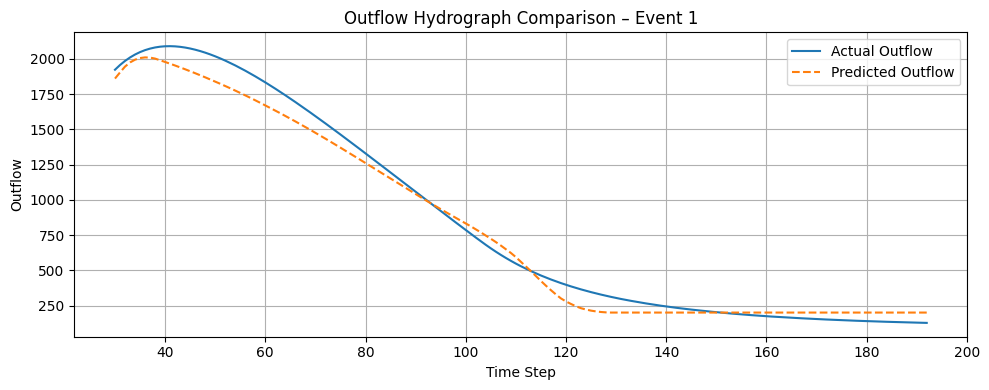

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


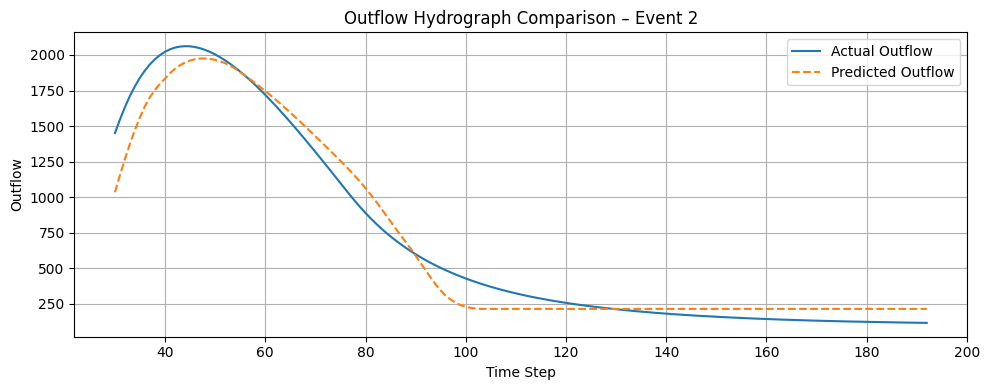

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 


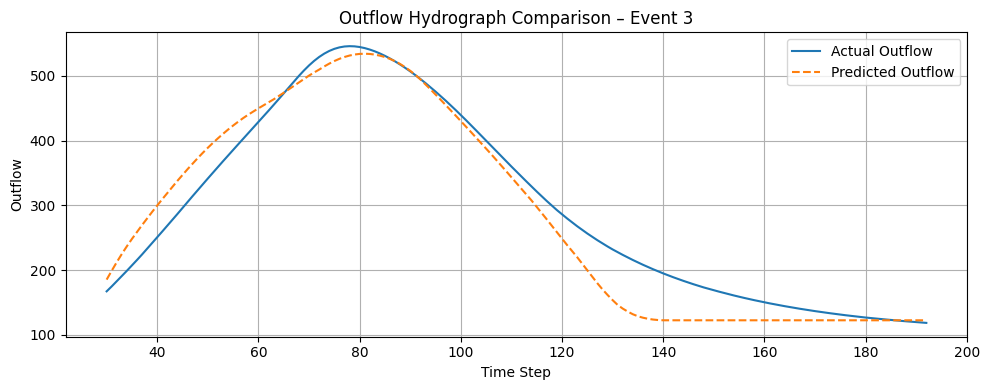

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 


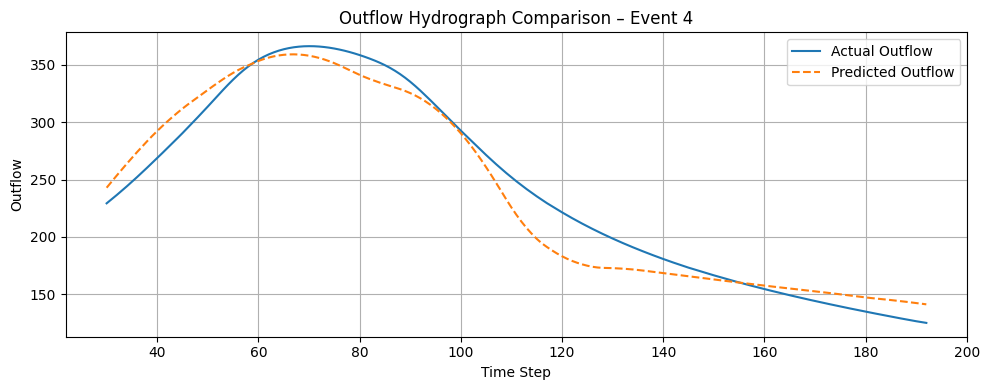

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 


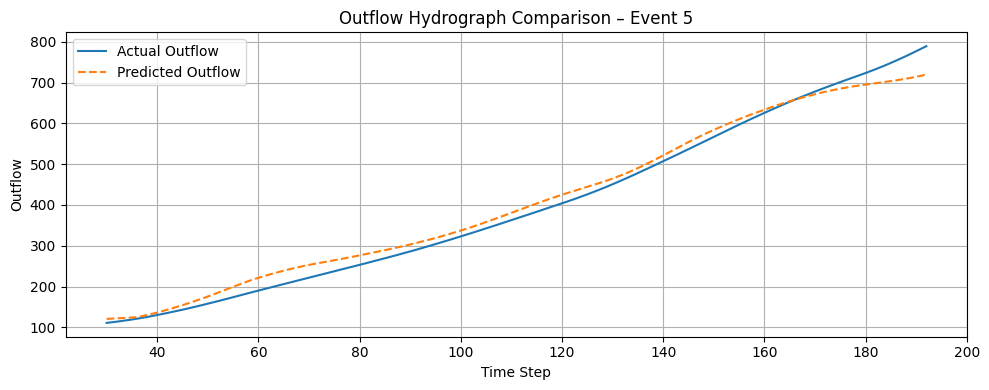

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 


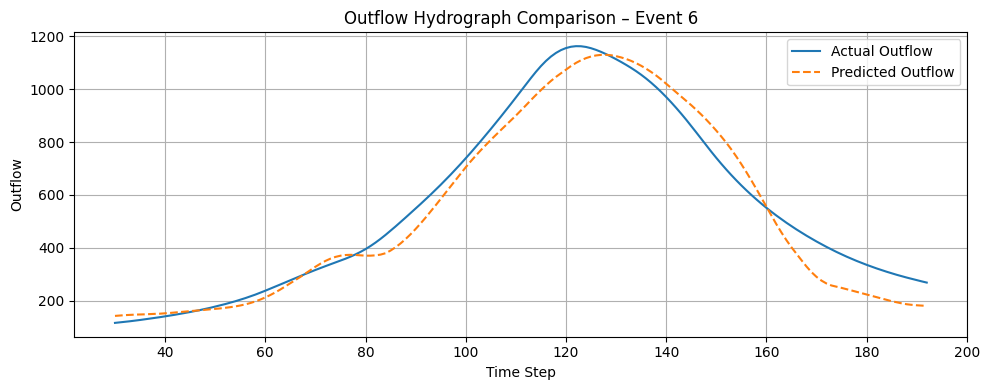

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 


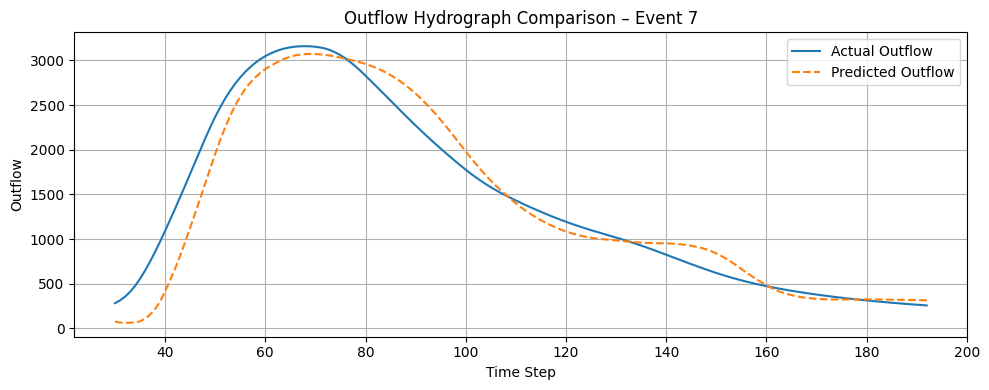

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 


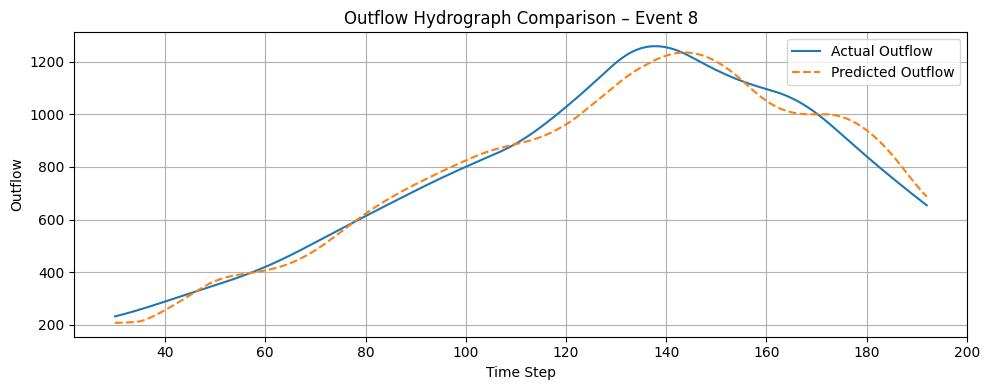

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 


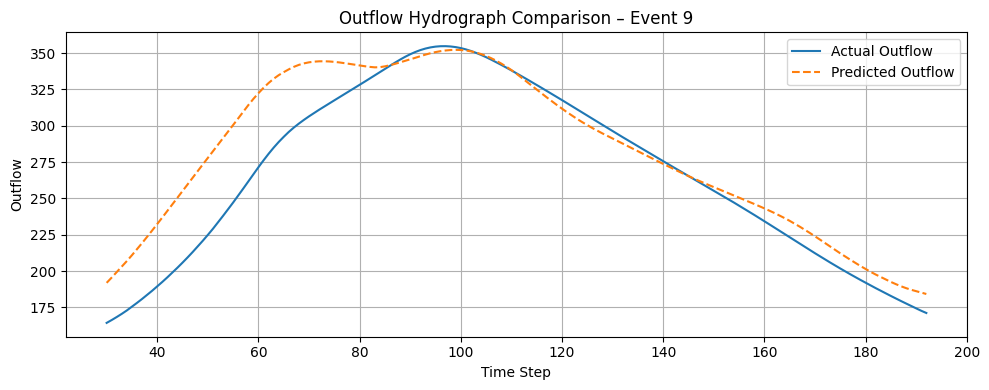

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 


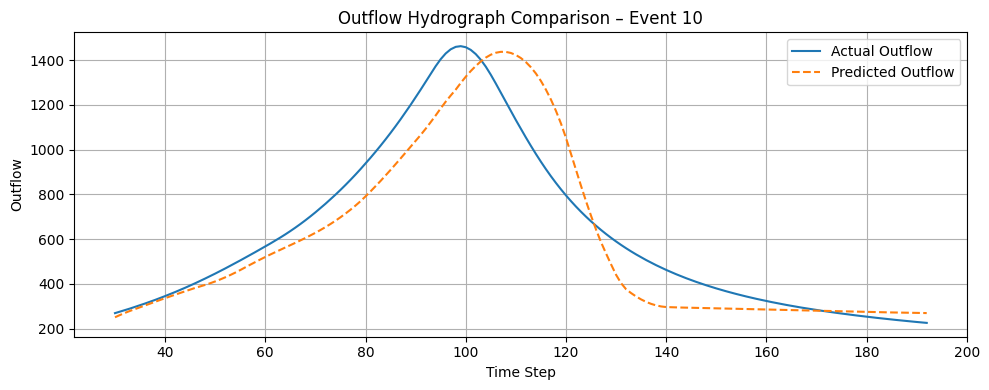

In [ ]:
# Extension: Compare full events (columns) – Actual vs Predicted Outflow

def plot_full_event_comparison(model, inflow_df, outflow_df, window_size, num_events=10):
    for i in range(num_events):
        # Extract single event
        inflow_series = inflow_df.iloc[:, i].values.reshape(-1, 1)
        outflow_series = outflow_df.iloc[:, i].values.reshape(-1, 1)

        # Scale
        scaler_in = MinMaxScaler()
        scaler_out = MinMaxScaler()
        inflow_scaled = scaler_in.fit_transform(inflow_series)
        outflow_scaled = scaler_out.fit_transform(outflow_series)

        # Generate sequences
        X_event, y_event = create_sequences_from_series(inflow_scaled, outflow_scaled, window_size)
        X_event = X_event.reshape((X_event.shape[0], X_event.shape[1], 1))

        # Predict
        y_pred_scaled = model.predict(X_event)
        y_pred = scaler_out.inverse_transform(y_pred_scaled)
        y_actual = scaler_out.inverse_transform(y_event)

        # Align with original time (for plotting)
        time = np.arange(window_size, len(inflow_series))

        # Plot
        plt.figure(figsize=(10, 4))
        plt.plot(time, y_actual, label='Actual Outflow')
        plt.plot(time, y_pred, label='Predicted Outflow', linestyle='--')
        plt.title(f'Outflow Hydrograph Comparison – Event {i + 1}')
        plt.xlabel('Time Step')
        plt.ylabel('Outflow')
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()

# Call function to plot all 10 events
plot_full_event_comparison(model, inflow_df, outflow_df, window_size=30, num_events=10)
